## Distance between interpolated images in neural network space

We've created a set of images that interpolate between two base images (e.g. grass, leaves). Those images are made by initializing a noise image and iterating it to match the featural co-occurances to another image - or, in our case, to weighted sums of the featural co-occurances of two different images. We hope/expect that these interpolated images fall along some 1-d axis - the same way that contrast, or orientation does. The goal of this notebook is to test if this is case with our synthesized images. Here, "distance" is implemented in neural network space - the L1 difference between the activations of features in some late pooling layer of vgg19.

First, import all the stuff you need.

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import warnings
import os
import pdb
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import itertools
import pickle
import warnings
from scipy.optimize import fmin
from scipy.stats import norm
from PIL import Image
import random
import pdb
import matplotlib.colors as mcolors

warnings.filterwarnings("ignore")

Next, set up the different models you might want to use. Here, you should define the different layers are which you want to pull out the activations.

In [2]:
def get_model(model_name):
    activations = []

    def get_activation(name):
        def hook(model, input, output):
            activations.append(output)
        return hook

    if model_name == 'VGG19':
        model = models.vgg19(pretrained=True)
        layers_to_extract = ['features.0', 'features.5', 'features.10', 'features.19', 'features.28', 'classifier.6']
    elif model_name == 'ResNet50':
        model = models.resnet50(pretrained=True)
        layers_to_extract = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
    elif model_name == 'InceptionV3':
        model = models.inception_v3(pretrained=True)
        layers_to_extract = ['Conv2d_1a_3x3', 'Conv2d_2a_3x3', 'Conv2d_2b_3x3', 'Mixed_5b', 'Mixed_6a', 'fc']
    elif model_name == 'EfficientNet_B0':
        model = models.efficientnet_b0(pretrained=True)
        layers_to_extract = ['features.0', 'features.2', 'features.4', 'features.6', 'classifier.1']
    elif model_name == 'EfficientNet_V2S':
        model = models.efficientnet_v2_s(pretrained=True)
        layers_to_extract = ['features.0', 'features.2', 'features.4', 'features.6', 'classifier.1']
    elif model_name == 'DenseNet201':
        model = models.densenet201(pretrained=True)
        layers_to_extract = ['features.conv0', 'features.denseblock1', 'features.denseblock2', 'features.denseblock3', 'features.denseblock4', 'classifier']
    elif model_name == 'Swin_T':
        model = models.swin_t(pretrained=True)
        layers_to_extract = ['features.0', 'features.1', 'features.2', 'features.3', 'norm', 'head']
    elif model_name == 'ViT':
        model = models.vit_b_16(pretrained=True)
        layers_to_extract = ['conv_proj', 'encoder', 'heads']
    else:
        raise ValueError("Model name not recognized. Please choose a valid model name.")
    
    model.eval()
    
    # Register hooks to capture the outputs of the selected layers
    for layer_name in layers_to_extract:
        layer = dict([*model.named_modules()])[layer_name]
        layer.register_forward_hook(get_activation(layer_name))
    
    return model, activations, layers_to_extract

Function to preprocess the images. Normalizes the images to look like the training data. I also have a "load image" function which loads the image without adjusting the colors (so they look normal).

In [3]:
def preprocess_image(img_path, input_size):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Create a mini-batch as expected by the model
    return image

def load_image(img_path, input_size):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ])
    image = Image.open(img_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Create a mini-batch as expected by the model
    return image

### Get activations at different layers of a specified network in response to the images.

First, define the model you want to use (needs to be in the library above). It will get activations at all of the layers you defined above in get_model, but you should specify one layer here that you want to actually visualize for the next part (mds, RSA).

out/acorns_redwood/10x10/acorns_0.0_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_0.1_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_0.2_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_0.3_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_0.4_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_0.5_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_0.6_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_0.7_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_0.8_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_0.9_redwood_10x10_pool4_smp1.png
out/acorns_redwood/10x10/acorns_1.0_redwood_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.0_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.1_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.2_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.3_leaves_10x10_pool4_smp1.png
out/grass_leaves/10x10/grass_0.4_leaves_1

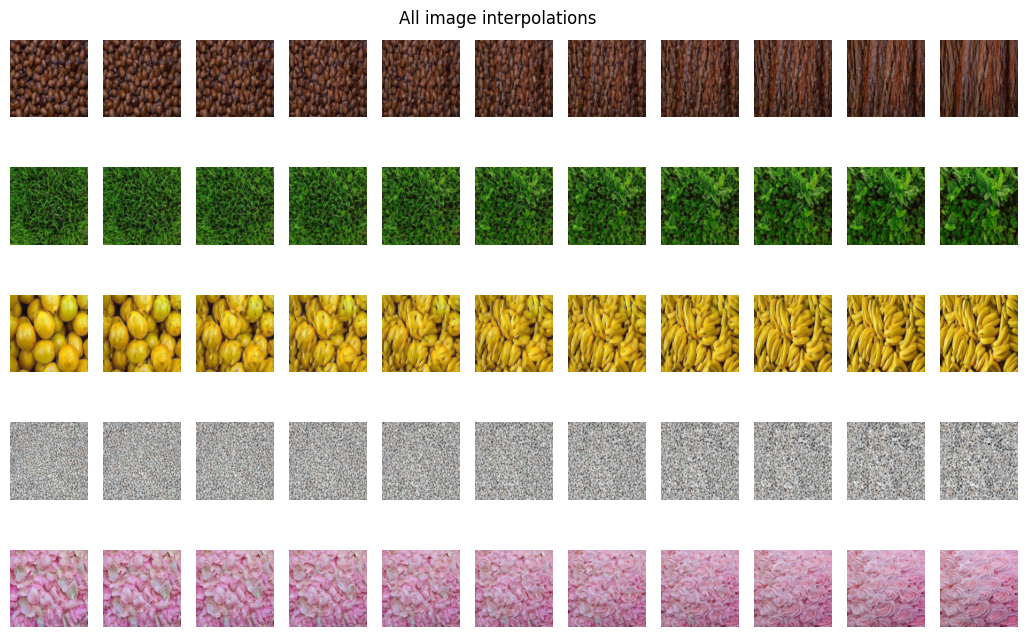

In [4]:
model_name = 'ResNet50'  # Change this to the desired model name
layer = 2
saveFigures = 0
activationLoss = 0
input_size = 224 if model_name != 'InceptionV3' else 299  # Set input size based on model

# Load the model and initialize the activation hooks
model, activations, layers_to_extract = get_model(model_name)

image1Names = ['acorns', 'grass', 'lemons', 'pebbles', 'petals']
image2Names = ['redwood', 'leaves', 'bananas', 'granite', 'buttercream']

interpValues = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
interpNames = [f"{string1}_{string2}" for string1, string2 in zip(image1Names, image2Names)]

allActivations = {}; allImages = {}; imageNames = []; imageIndex = 0;

fig, axes = plt.subplots(ncols=len(interpValues), nrows=len(interpNames), figsize=(13, 8)); sub = 0;
for interpName in interpNames:
    for interpValue in interpValues:
        img_path = os.path.join('out', interpName, '10x10', 
                f"{image1Names[imageIndex]}_{interpValue}_{image2Names[imageIndex]}_10x10_pool4_smp1.png")
        imageName = f"{interpName}_{interpValue}"
        # Different name if doing activation loss images
        if activationLoss == 1:
            img_path = 'fades/' + image1Names[imageIndex] + '_' + str(interpValue) + '_' + image2Names[imageIndex] + '_pool4_smp1.png'
        print(img_path)
        x = preprocess_image(img_path, input_size)
        unprocessed_image = load_image(img_path, input_size)
        
        # Reset activations
        activations.clear()

        # Forward pass through the model
        with torch.no_grad():
            model(x)

        # Save outputs
        allActivations[imageName] = [activation.numpy() for activation in activations]
        allImages[imageName] = unprocessed_image.squeeze(0).permute(1, 2, 0).numpy()  # Save the original image
        imageNames.append(imageName)

        # Plot the image
        im = axes.flatten()[sub].imshow(allImages[imageName])
        axes.flatten()[sub].axis('off')
        sub += 1

    imageIndex += 1

plt.suptitle('All image interpolations', y=.9)
plt.show()

### Calculate distances between images in a specified layer

Next, we'll plot the dissimilarities between the interpolations for every image pair. Dissimilarity is just the cosine distance between the activations of all the features in a specified layer. This is just to visualize one layer - don't get too hung up on it.

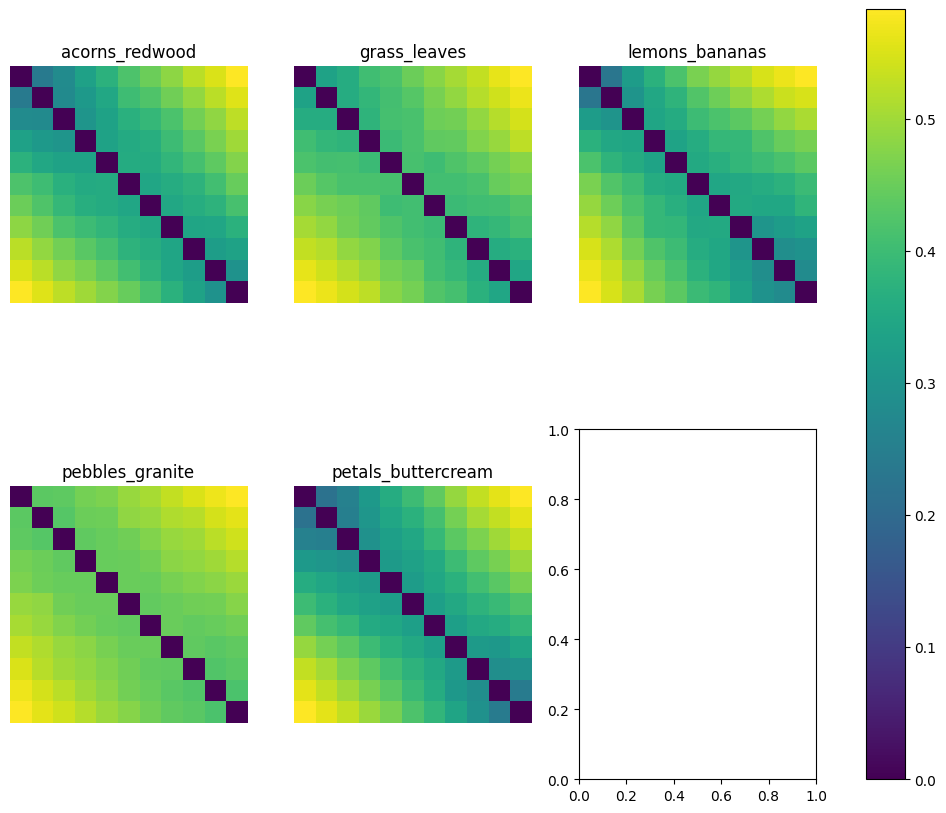

In [5]:
# set your layer - numbers defined earlier
layer_names = ['','','','','','Classification layer'];

# get L1 distance between all images
distances = np.zeros((len(imageNames),len(imageNames)))
for im1 in range(len(imageNames)):
    for im2 in range(len(imageNames)):
        #distances[im1,im2] = np.sum(np.abs(allActivations[imageNames[im1]][layer] - allActivations[imageNames[im2]][layer]))
        distances[im1,im2] = scipy.spatial.distance.cosine(allActivations[imageNames[im1]][layer].flatten(), allActivations[imageNames[im2]][layer].flatten())

# pull out the individual interpolations
singleInterpDistanceMatrices = {}; nameIndex = 0;
for interpImage in range(0, distances.shape[0], len(interpValues)):
    singleInterpDistanceMatrices[interpNames[nameIndex]] = \
    distances[interpImage:interpImage+len(interpValues), interpImage:interpImage+len(interpValues)];
    
    nameIndex+=1

# plot individual matrices
avgDistance = np.zeros((len(interpValues), len(interpValues)))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 10))
for sub in range(len(interpNames)):
    im = axes.flatten()[sub].imshow(singleInterpDistanceMatrices[interpNames[sub]])
    axes.flatten()[sub].set_title(interpNames[sub])
    axes.flatten()[sub].axis('off')
    avgDistance += singleInterpDistanceMatrices[interpNames[sub]]

# hide extra subplots
for ax in axes.flatten()[len(interpValues):]:
    ax.axis('off')
    
fig.colorbar(im, ax=axes);

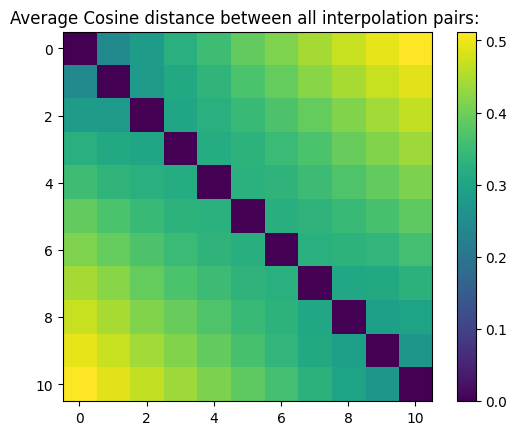

In [6]:
# Plot the averaged dissimilarity matrix
plt.imshow(avgDistance/5);
plt.title('Average Cosine distance between all interpolation pairs: ');
plt.colorbar();

### MDS and tsne
Let's look at the mds and tsne embeddings of the representations in this specific layer. Again, you shouldn't look for conclusions here - but there may be some hints about the geometry of the embeddings.

First, let's look at the mds of the individual textures.

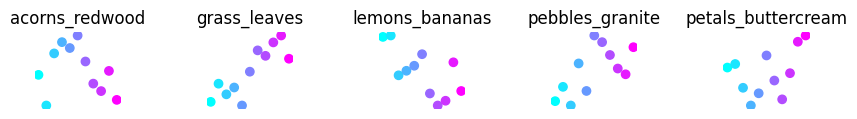

In [7]:
# initialize mds, figure, and scatterplot colors
mds = MDS(n_components=1, dissimilarity='precomputed')
fig, axes = plt.subplots(nrows=1, ncols=len(interpNames), figsize=(10, 1), gridspec_kw={'hspace': .5, 'wspace': 1})
colors = [i for i in range(0, 11)]

# plot every mds projection from the distance matrices
for sub in range(len(interpNames)):
    embedded_distances = mds.fit_transform(singleInterpDistanceMatrices[interpNames[sub]])

    ax = axes.flatten()[sub]
    ax.scatter(range(11),embedded_distances[:, 0], c=colors, cmap = 'cool')
    ax.set_title(interpNames[sub])
    axes.flatten()[sub].axis('off')
    #for i, (x, y) in enumerate(zip(embedded_distances[:, 0], embedded_distances[:, 1])):
    #    ax.text(x, y, imageNames[i][-3:], fontsize=8, ha='right')

# hide extra subplots
for ax in axes.flatten()[len(interpValues):]:
    ax.axis('off')

#### Let's look at the mds of the averaged RDM:

Text(0.5, 1.0, 'Average mds projection: ')

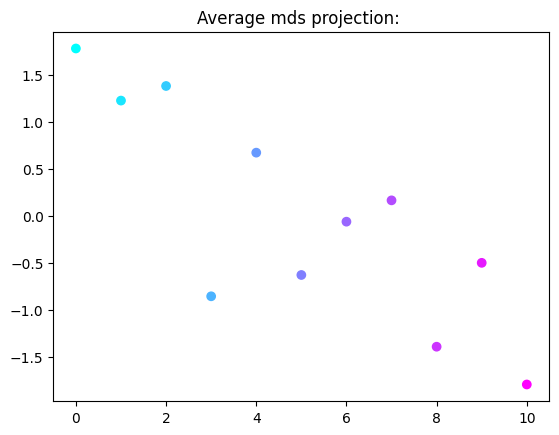

In [8]:
# plot the mds projection of the average distance matrix
avg_embedded_distances = mds.fit_transform(avgDistance)

plt.scatter(range(11), avg_embedded_distances[:, 0], c=colors, cmap='cool')
plt.title('Average mds projection: ' + layer_names[layer])
#for i, (x, y) in enumerate(zip(avg_embedded_distances[:, 0], avg_embedded_distances[:, 1])):
#    plt.text(x, y, imageNames[i][-3:], fontsize=8, ha='right')

#### Try tsne on, with different perplexities, on the averaged RDM:

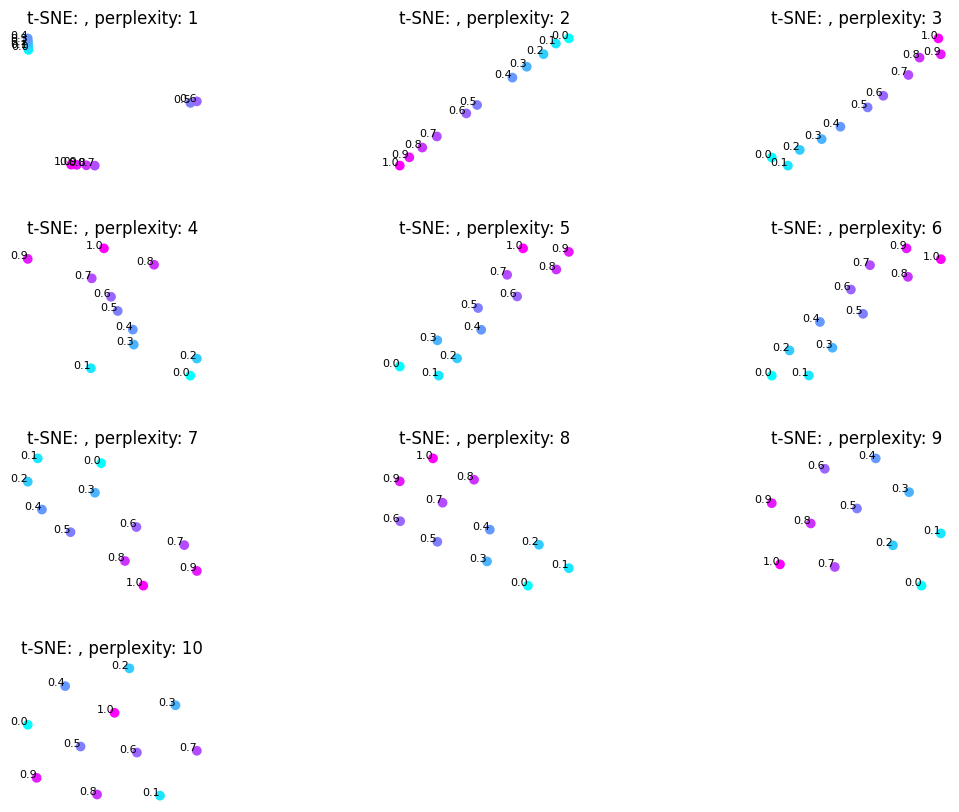

In [9]:
# let's try tsne...
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10), gridspec_kw={'hspace': .5, 'wspace': 1})

sub = 0
for perp in range(1,11):
    tsne = TSNE(n_components=2, perplexity = perp) 
    avg_embedded_tsne = tsne.fit_transform(avgDistance)
    
    # plot it
    ax = axes.flatten()[sub]
    ax.scatter(avg_embedded_tsne[:, 0], avg_embedded_tsne[:, 1], c=colors, cmap='cool')
    ax.set_title('t-SNE: ' + layer_names[layer] + ', perplexity: ' + str(perp))
    axes.flatten()[sub].axis('off')
    
    # label interps
    for i, (x, y) in enumerate(zip(avg_embedded_tsne[:, 0], avg_embedded_tsne[:, 1])):
        ax.text(x, y, imageNames[i][-3:], fontsize=8, ha='right')

    sub+=1

# hide extra subplots
for ax in axes.flatten()[10:]:
    ax.axis('off')

### MLDS

Now, let's get to maximum likelihood distance scaling. First, define the loss function that you will use to optimze the psi values:

In [10]:
# define loss function to compute scaling values
def compute_loss(params, all_combinations, biggerDiff):
    psi = params[:11]
    sigma = params[11]
    
    # make a copy here of all the combinations
    all_combinations_copy = np.copy(all_combinations)
    all_combinations_copy = all_combinations_copy/10
    
    # replace with the psi values
    for interp_val in range(11):
        all_combinations_copy[all_combinations == interp_val] = psi[interp_val]

    # calculate the differences and probabilitys
    diffs = np.abs(all_combinations_copy[:, 0] - all_combinations_copy[:, 1]) - np.abs(all_combinations_copy[:, 2] - all_combinations_copy[:, 3])
    total_prob = 0
    for response_num in range(len(diffs)):
        if biggerDiff[response_num] == 1:
            prob_response = -np.log(norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
        elif biggerDiff[response_num] == 2:
            prob_response = -np.log(1-norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
    return total_prob

#### Make combinations of different pairs, to simulate draws in the mlds experiment.

In [11]:
# make combinations
#all_combinations = np.zeros((330,4))  # Initialize array to hold combinations
#col = 0

#for i in range(0, len(interpValues)):
#    for j in range(i + 1, len(interpValues)):
#        for k in range(j + 1, len(interpValues)):
#            for l in range(k + 1, len(interpValues)):
#                all_combinations[col,:] = np.array([round(i), round(j), round(k), round(l)])
#                col += 1

#all_combinations = np.array(all_combinations)

# make all of the different permutations. this is way, way too long - will fix later.
#all_combinations = np.array(list(itertools.product(range(0,len(interpValues)), repeat=4)))

# do it like in the human experiment - random numbers
all_combinations = np.random.randint(0, 11, size=(2000, 4))

#### Now, actually do the mlds.

You should specify what layers you want to do this in. The code will only do within specific layers. At some point, I will add the ability to use multiple layers at once. The layer indices should be the indicies of the layers_to_extract list from earlier. This will save out the psi values in the form Psis{layer}{interpolation family}.

Optimization terminated successfully.
         Current function value: 317.126528
         Iterations: 701
         Function evaluations: 989
Optimization terminated successfully.
         Current function value: 360.747672
         Iterations: 954
         Function evaluations: 1321
Optimization terminated successfully.
         Current function value: 321.037483
         Iterations: 909
         Function evaluations: 1278
Optimization terminated successfully.
         Current function value: 868.078787
         Iterations: 956
         Function evaluations: 1307
Optimization terminated successfully.
         Current function value: 191.225859
         Iterations: 755
         Function evaluations: 1065
Optimization terminated successfully.
         Current function value: 248.846146
         Iterations: 631
         Function evaluations: 882
Optimization terminated successfully.
         Current function value: 230.621876
         Iterations: 636
         Function evaluations: 899
Op

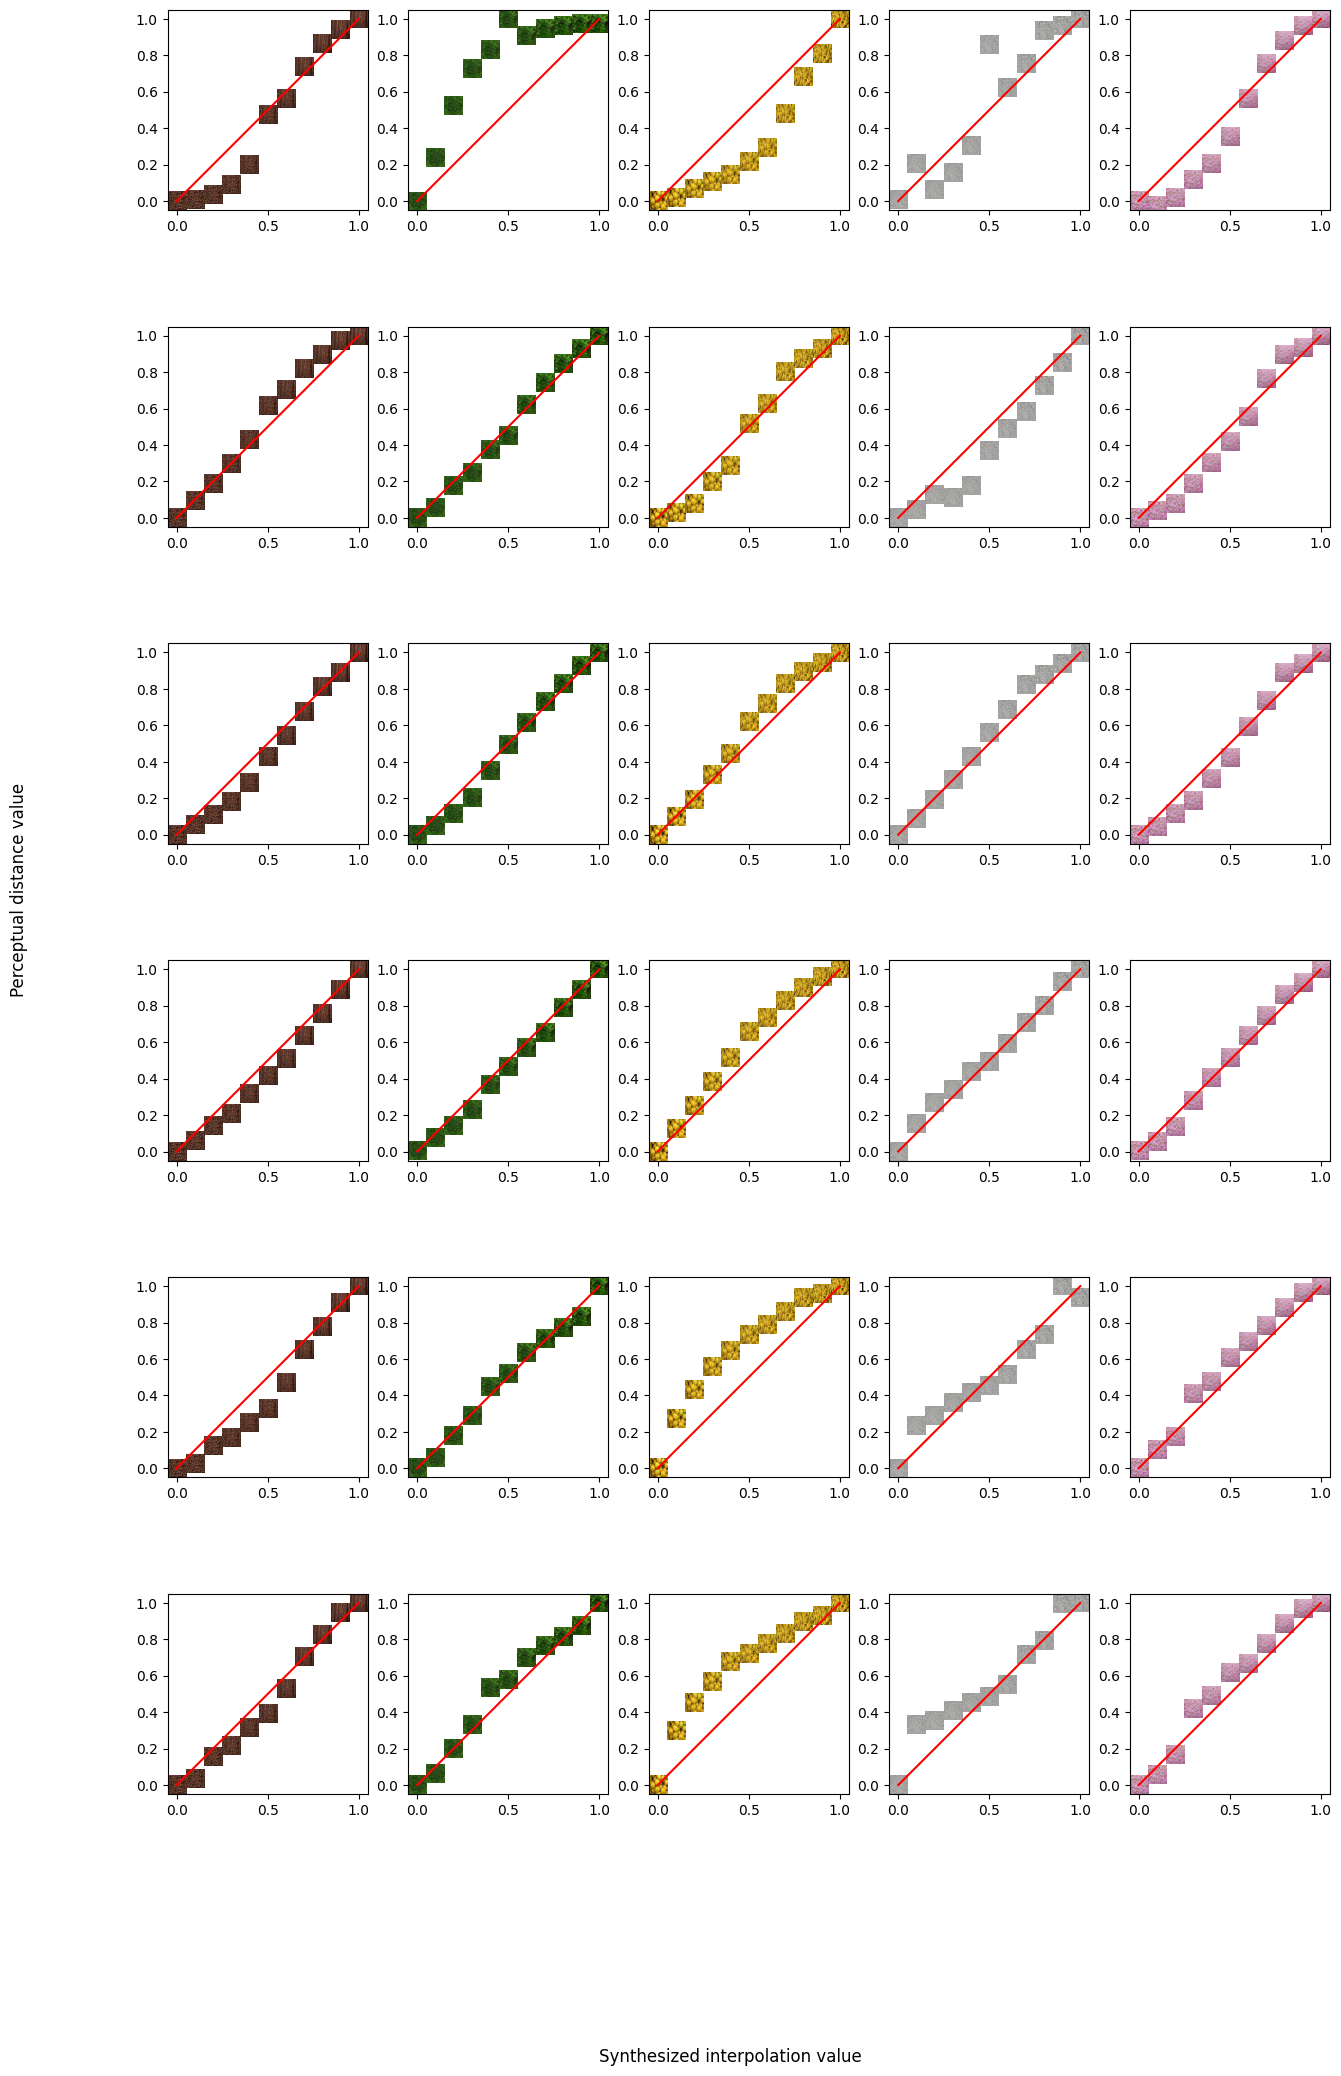

In [12]:
# pick which layers you want to look at
#layers = [conv1, pool1, pool2, pool3, pool4, pool5, end]
layers = [0,1,2,3,4,5]
Psis = {};
mldsSigmas = {};

# init a figure
fig = plt.figure(figsize=(15, 4*len(layers)))
sub = 0;

for layer in layers:

    # iterate through interpolations
    for interpPair in range(len(interpNames)):
        
        # make some empty lists to keep track
        biggerDiff = [];
        
        for pairings in all_combinations.astype(int):
            # add which interp number this is by adding amount of pairs you've iterated * num interp values
            pairings = tuple(x + interpPair*len(interpValues) for x in pairings)
            # get the index from all activations to the pairs
            im1 = pairings[0]; im2 = pairings[1]; im3 = pairings[2]; im4 = pairings[3];
            # calcuate the distances
            dist12 = scipy.spatial.distance.cosine(allActivations[imageNames[im1]][layer].flatten(), allActivations[imageNames[im2]][layer].flatten())
            dist34 = scipy.spatial.distance.cosine(allActivations[imageNames[im3]][layer].flatten(), allActivations[imageNames[im4]][layer].flatten())
            if dist12 > dist34:
                biggerDiff.append(1)
            elif dist34 > dist12:
                biggerDiff.append(2)
            else:
                biggerDiff.append(0)
        
        
        # set up initial params
        psi = np.arange(0, 11)/10 #np.random.rand(11)#
        sigma = 0.2
        initial_params = np.concatenate((psi, [sigma]))
        
        # search for params
        optimal_params = fmin(compute_loss, initial_params, args=(all_combinations, biggerDiff));
        psi = optimal_params[:11]
        psi = psi / np.max(psi)
        Psis[(layer, interpPair)] = psi;
        mldsSigmas[(layer, interpPair)] = optimal_params[11];
        
        # plot it
        plt.subplot(len(layers),len(image1Names),interpPair+1+sub*len(image1Names))
        
        # iterate over interp_values
        for interp_value in range(11):
            im = interpPair * len(interpValues) + interp_value
            plt.imshow(allImages[imageNames[im]], extent=[(interp_value ) / 10 - 0.05, (interp_value) / 10 + 0.05, psi[interp_value] - 0.05, psi[interp_value] + 0.05])
       
        # set axis limits
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.plot([0, 1], [0, 1], 'r')

    sub += 1        
# show the plot
fig.supylabel('Perceptual distance value')
fig.supxlabel('Synthesized interpolation value')
if saveFigures:
    plt.savefig('nn_mlds_figures/' + model_name + '.pdf')
plt.show()


### Comparison to psychophysical data

Ok - so we have the psi values for different layers of the network for different image interpolations. The fancy way to say this is that we have the *representational geometry* of the interpolated images at the different layers. Conveniently, we also have that for psychophysical data as well.

Next, we'll load in the psi values fit to the psychophysical data and see how well they correlate with the psi values fit to the simulated psychophysical data from the neural network embeddings at the different layers. Again, the fancy way to say this is that we are going to compare the network representational geometry at different layers with the perceptual geometry measured from human subjects.

First, load in the psychophysical data (this is computed and saved out by the function "mldsAnal.m" which works with stimfiles saved out from "texMlds.m", which should use the same interpolation familes):

In [13]:
PsychophysicsData = scipy.io.loadmat(os.path.expanduser('~/data/texMlds/texMldsGroupData.mat'),  struct_as_record=False, squeeze_me=True)
PPdata = PsychophysicsData['data']

Now, let's look at each texture individually. Let's plot the neural network psi values against the human perceptual psi values, for each texture (rows) and each layer (columns).

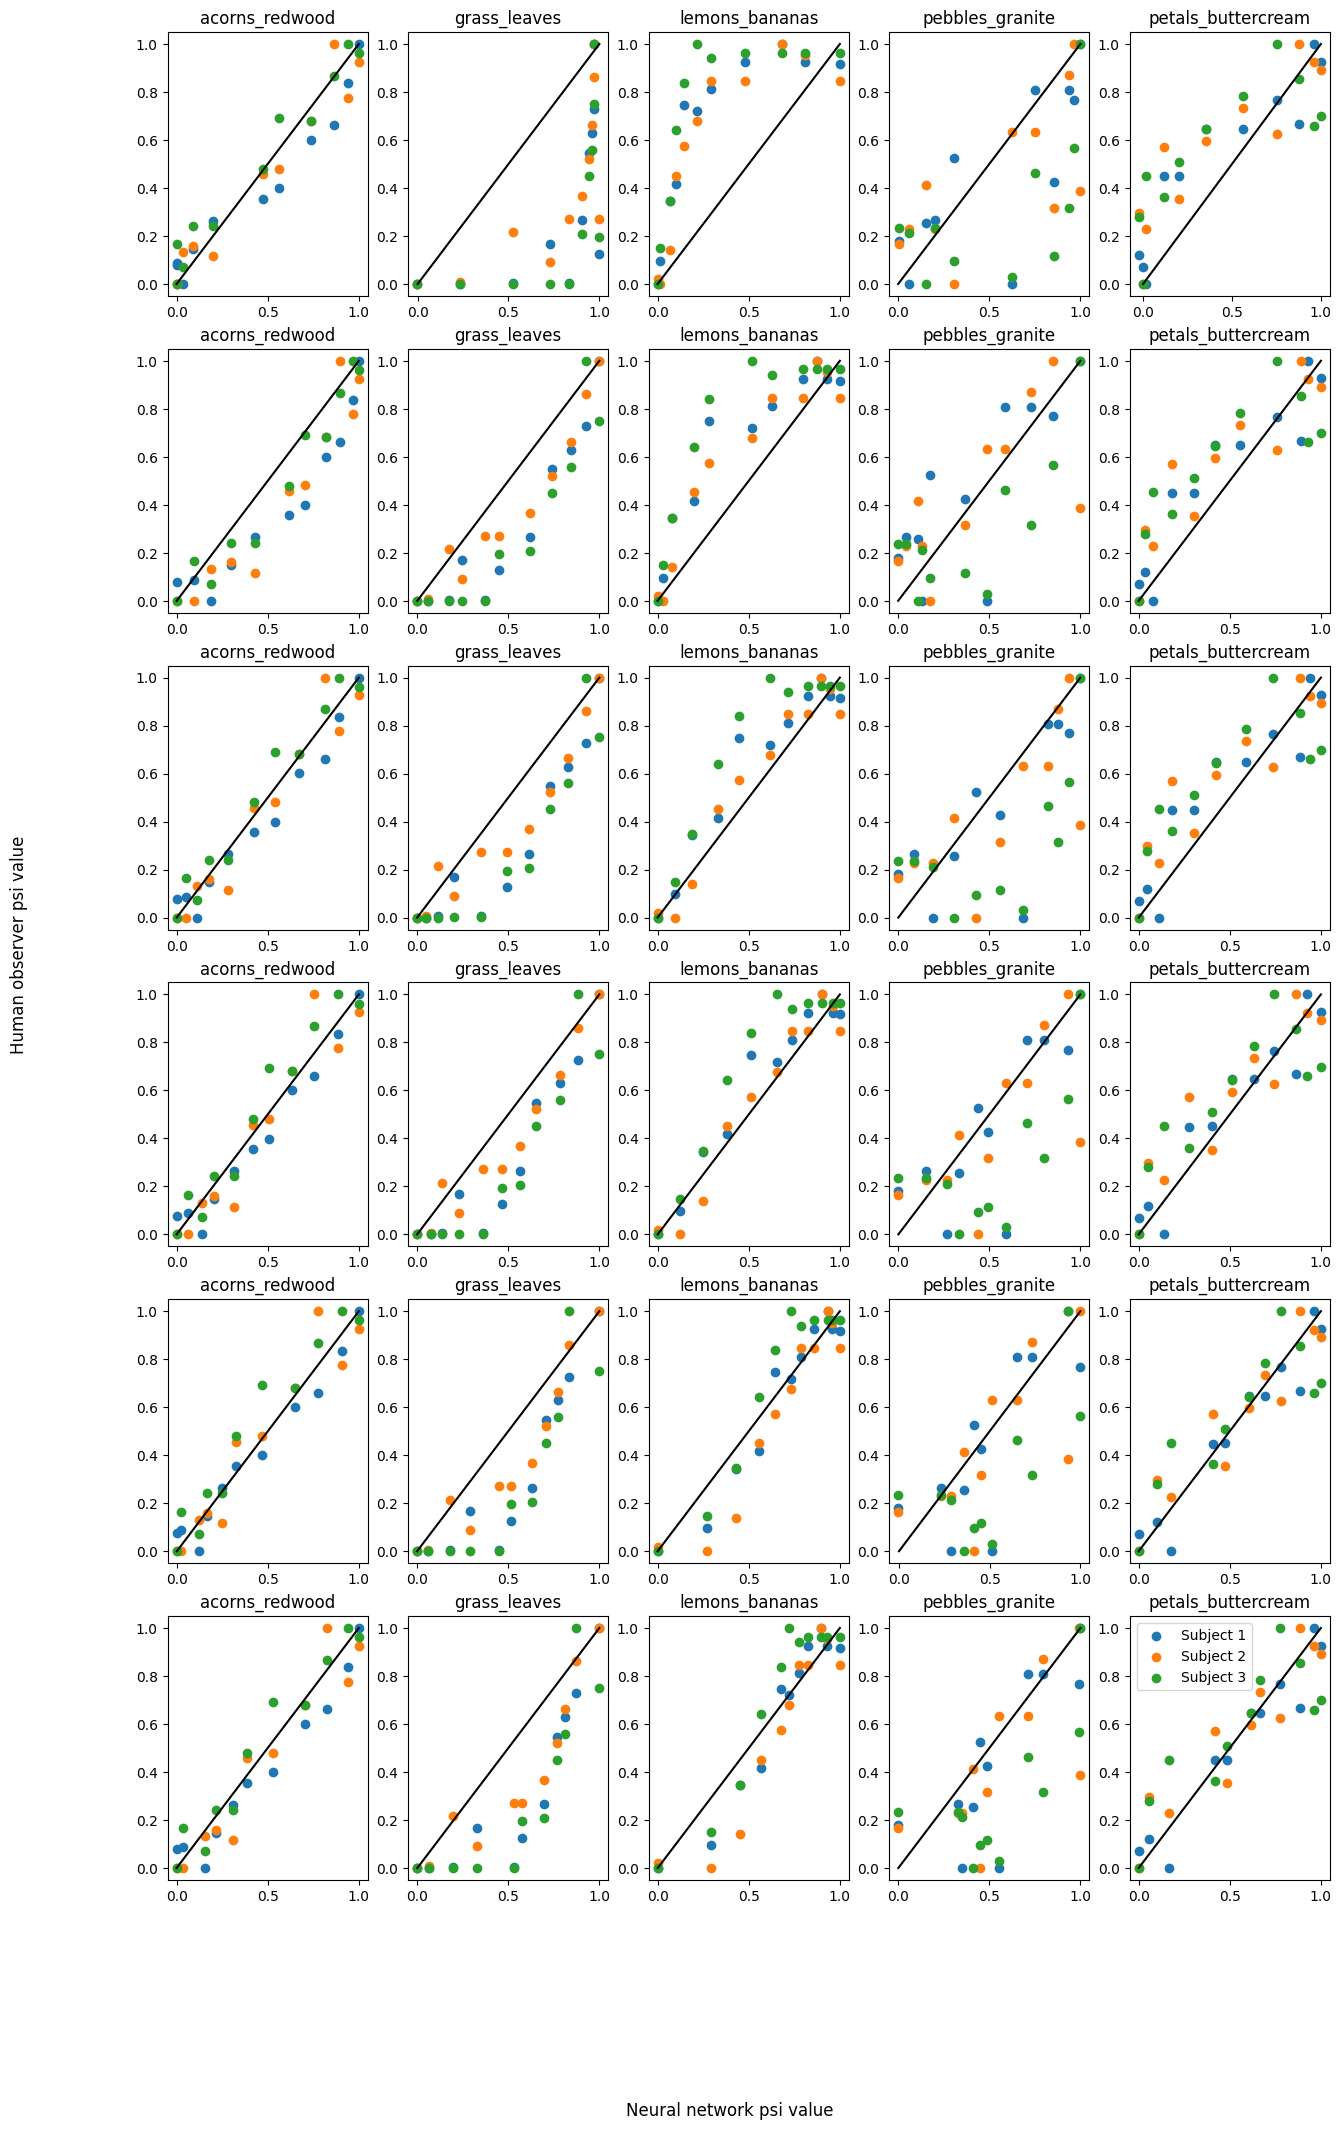

In [14]:
texIndices = [0, 1, 2, 3, 4]

#plot the individual interpolations on their own subplots
fig = plt.figure(figsize=(15, 4*len(layers)))
sub = 0
for layerIndex in range(0,len(layers)):
    for tex in texIndices:
        plt.subplot(len(layers),len(texIndices), 1+tex+sub*len(texIndices)+len(texIndices)*layerIndex)
        plt.title(interpNames[tex])
        plt.plot([0,1],[0,1],'k')
        for subject in range(len(PPdata.SIDnums)):
            plt.scatter(Psis[(layers[layerIndex],tex)], PPdata.psi[subject][tex], label=f'Subject {subject+1}')

fig.supylabel('Human observer psi value')
fig.supxlabel('Neural network psi value')

plt.legend()
        

If we want a metric to compare the geometries, we can put all the textures together. Then, for each layer, we can calculate an R2 as the match between the NN layer psi values and human perceptual psi values for all of the textures together. 

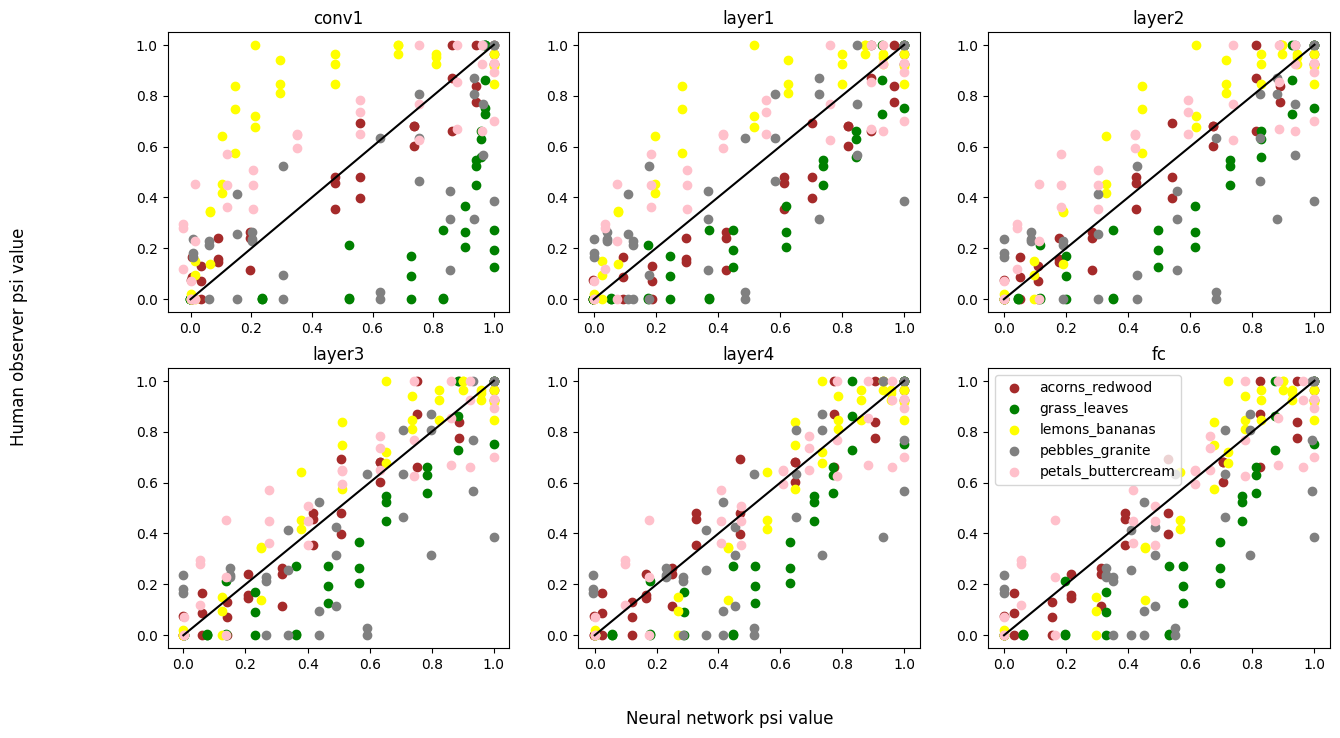

In [29]:
#plot everything together, colored by interpolation
colors = ['brown','green','yellow','grey','pink']

fig = plt.figure(figsize=(15, 8))
sub = 0

for layerIndex in range(0,len(layers)):
    plt.subplot(2, 3, layerIndex+1)
    plt.plot([0,1],[0,1],'k')
    plt.title(layers_to_extract[layers[layerIndex]])
    for tex in texIndices:
        for subject in range(len(PPdata.SIDnums)):
            plt.scatter(Psis[(layers[layerIndex],tex)], PPdata.psi[subject][tex], label=interpNames[tex] if subject == 0 else "", color=colors[tex])


fig.supylabel('Human observer psi value')
fig.supxlabel('Neural network psi value')

plt.legend()


Text(0.5, 1.0, 'r-squared between ResNet50 layer representational geometry and human perceptual geometry')

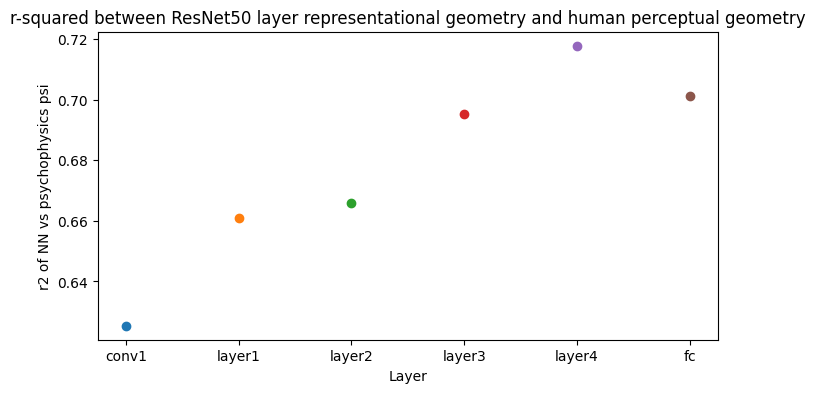

In [45]:
fig = plt.figure(figsize=(8, 4))

for layer in layers:
    plt.scatter(layer, np.corrcoef(Psis[(layers[layer],tex)], PPdata.psi[subject][tex])[0,1] ** 2)  

plt.xticks(layers, layers_to_extract)
plt.xlabel('Layer')
plt.ylabel('r2 of NN vs psychophysics psi')
plt.title('r-squared between ' + model_name + ' layer representational geometry and human perceptual geometry')

In [44]:
model_name

'ResNet50'